In [1]:
import hashlib
import json
import time
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, ConnectionPatch
import matplotlib.dates as mdates
from datetime import datetime

class Transaction:
    def __init__(self, sender, receiver, amount):
        self.sender = sender
        self.receiver = receiver
        self.amount = amount

    def __repr__(self):
        return f"Transaction({self.sender} -> {self.receiver}: {self.amount})"

        
class Block:
    def __init__(self, index, timestamp, transactions, previousHash, nonce=0):
        self.index = index
        self.timestamp = timestamp
        self.transactions = transactions  # List of transactions
        self.previousHash = previousHash
        self.nonce = nonce
        self.hash = self.computeHash()

    def computeHash(self):
        # Serialize block's data and compute the SHA-256 hash
        block_string = json.dumps({
            'index': self.index,
            'timestamp': self.timestamp,
            'transactions': [t.__dict__ for t in self.transactions],  # Serialize transactions
            'previous_hash': self.previousHash,
            'nonce': self.nonce
        }, sort_keys=True).encode()

        return hashlib.sha256(block_string).hexdigest()

    


In [2]:
class Blockchain:
    def __init__(self):
        self.chain = []  # The list of blocks
        self.difficulty = 2  # Difficulty level for mining
        self.createFirstBlock()

    def createFirstBlock(self):
        # Manually create the first block with fixed values
        firstBlock = Block(0, time.time(), [], "0")  # Empty transaction list for the genesis block
        self.chain.append(firstBlock)

    def addBlock(self, transactions):
        previousBlock = self.chain[-1]
        newBlock = Block(index=previousBlock.index + 1, timestamp=time.time(), transactions=transactions, previousHash=previousBlock.hash)
        newBlock.hash = self.proofOfWork(newBlock)
        self.chain.append(newBlock)

    def proofOfWork(self, block):
        # Adjust nonce until the block's hash satisfies the difficulty level (e.g., starts with '00')
        block.nonce = 0
        computedHash = block.computeHash()
        while not computedHash.startswith('0' * self.difficulty):
            block.nonce += 1
            computedHash = block.computeHash()
        return computedHash

    def isChainValid(self):
        # Verify that the blockchain is valid by checking hashes
        for i in range(1, len(self.chain)):
            currentBlock = self.chain[i]
            previousBlock = self.chain[i - 1]
            
            # Check if current block's hash is correct
            if currentBlock.hash != currentBlock.computeHash():
                return False
            
            # Check if current block's previous hash matches the previous block's hash
            if currentBlock.previousHash != previousBlock.hash:
                return False

        return True

Mining block 1...
Mining block 2...
Mining block 3...


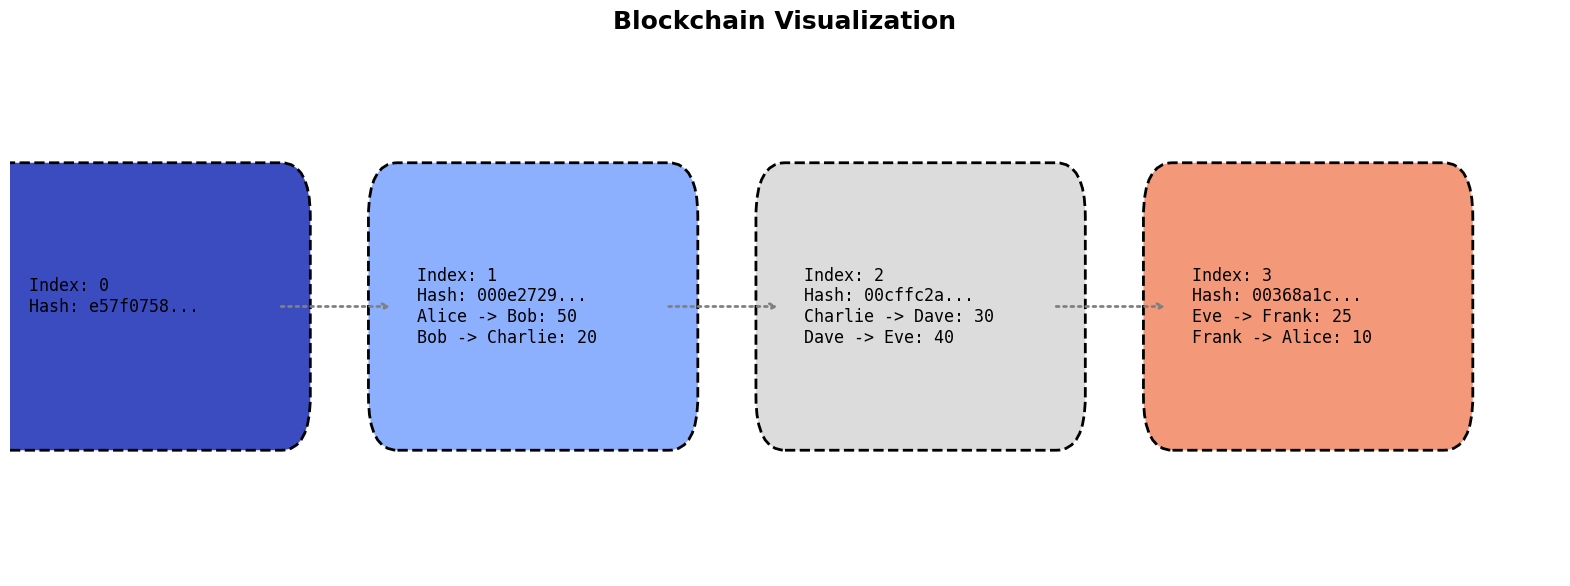

In [3]:
def visualizeBlockchain(blockchain):
    fig, ax = plt.subplots(figsize=(20, 7)) 

    # Set the color map and block spacing
    colors = plt.cm.coolwarm
    block_spacing = 4 
    arrow_offset = 0  
    
    for i, block in enumerate(blockchain.chain):
        color = colors(i / len(blockchain.chain))
        box = FancyBboxPatch((i * block_spacing, 1), 2.8, 1, boxstyle="round,pad=0.3", edgecolor="black", facecolor=color, linewidth=2, linestyle='--')
        ax.add_patch(box)

        # block details
        block_details = f"Index: {block.index}\nHash: {block.hash[:8]}...\n" + "\n".join([f"{t.sender} -> {t.receiver}: {t.amount}" for t in block.transactions])
        ax.text(i * block_spacing + 0.2, 1.5, block_details, fontsize=12, verticalalignment='center', family='monospace')

        if i > 0:
            conn = ConnectionPatch(xyA=((i-1) * block_spacing + 2.8, 1.5), xyB=(i * block_spacing - arrow_offset, 1.5), 
                                   coordsA='data', coordsB='data', axesA=ax, axesB=ax,
                                   arrowstyle="->", shrinkB=5, linewidth=2, color='gray', linestyle=':')
            ax.add_patch(conn)

    ax.set_xlim(0, len(blockchain.chain) * block_spacing)
    ax.set_ylim(0, 3)
    ax.axis('off')
    plt.title('Blockchain Visualization', fontsize=18, fontweight='bold')
    plt.show()




# Main block of code to run the blockchain
if __name__ == "__main__":
    blockchain = Blockchain()

    # Create some transactions
    transactions1 = [Transaction("Alice", "Bob", 50), Transaction("Bob", "Charlie", 20)]
    transactions2 = [Transaction("Charlie", "Dave", 30), Transaction("Dave", "Eve", 40)]
    transactions3 = [Transaction("Eve", "Frank", 25), Transaction("Frank", "Alice", 10)]
    # Add mined blocks to the blockchain
    blockchain.addBlock(transactions1)

    blockchain.addBlock(transactions2)

    blockchain.addBlock(transactions3)


    

visualizeBlockchain(blockchain)

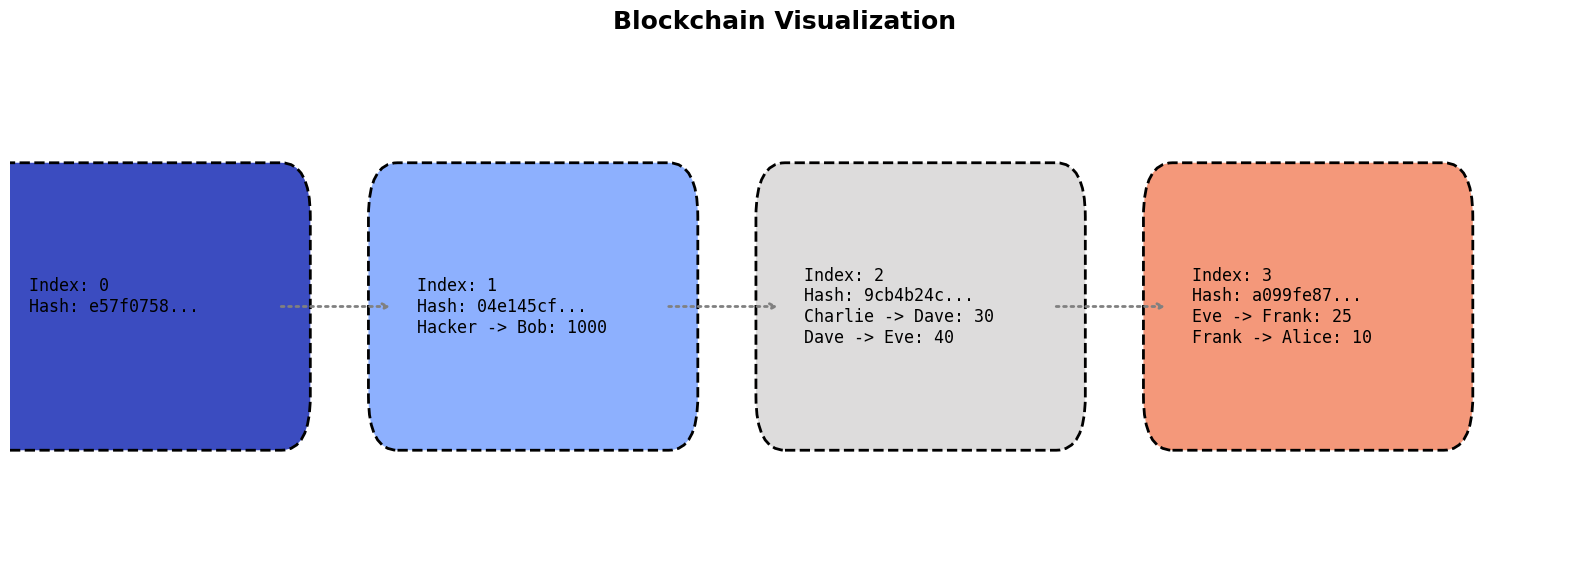

In [4]:
# Modify the data of a block (e.g., block 2)
blockchain.chain[1].transactions = [Transaction("Hacker", "Bob", 1000)]

# Recompute the hash for the modified block
blockchain.chain[1].hash = blockchain.chain[1].computeHash()

# Update the subsequent blocks
for i in range(2, len(blockchain.chain)):
    blockchain.chain[i].previousHash = blockchain.chain[i-1].hash
    blockchain.chain[i].hash = blockchain.chain[i].computeHash()

# Visualize the blockchain after tampering
visualizeBlockchain(blockchain)


In [2]:
import hashlib
import time

def generate_large_input(size_in_kb):
    """Generate a large string of the specified size in KB."""
    return "a" * (size_in_kb * 1024)  # Generate a string of 'a' repeated to reach the desired size

def hash_performance_test(hash_func, data, iterations=5):
    """Measure the average time it takes for a given hash function to process the data over multiple iterations."""
    start_time = time.perf_counter()
    for _ in range(iterations):
        hash_func(data.encode())  # Encode string data to bytes for hashing
    end_time = time.perf_counter()
    return (end_time - start_time) / iterations

def run_performance_comparison():
    input_sizes = [1, 1024, 1024 * 1024]  # Sizes in KB (e.g., 10 KB, 100 KB, 1 MB, 5 MB)
    iterations = 1000  # Increase iterations to reduce noise

    for size in input_sizes:
        data = generate_large_input(size)
        print(f"\nInput size: {size} KB (Averaged over {iterations} iterations)")

        # Test with SHA-256
        sha256_time = hash_performance_test(lambda d: hashlib.sha256(d).hexdigest(), data, iterations)
        print(f"SHA-256 time: {sha256_time:.6f} seconds")

        # Test with SHA-224
        sha224_time = hash_performance_test(lambda d: hashlib.sha224(d).hexdigest(), data, iterations)
        print(f"SHA-224 time: {sha224_time:.6f} seconds")
        
        # Test with SHA-1
        sha1_time = hash_performance_test(lambda d: hashlib.sha1(d).hexdigest(), data, iterations)
        print(f"SHA-1 time: {sha1_time:.6f} seconds")

        # Test with MD5
        md5_time = hash_performance_test(lambda d: hashlib.md5(d).hexdigest(), data, iterations)
        print(f"MD5 time: {md5_time:.6f} seconds")

if __name__ == "__main__":
    run_performance_comparison()



Input size: 1 KB (Averaged over 1 iterations)
SHA-256 time: 0.000013 seconds
SHA-224 time: 0.000008 seconds
SHA-1 time: 0.000013 seconds
MD5 time: 0.000011 seconds

Input size: 1024 KB (Averaged over 1 iterations)
SHA-256 time: 0.001081 seconds
SHA-224 time: 0.001011 seconds
SHA-1 time: 0.000844 seconds
MD5 time: 0.001290 seconds

Input size: 1048576 KB (Averaged over 1 iterations)
SHA-256 time: 0.701416 seconds
SHA-224 time: 0.706497 seconds
SHA-1 time: 0.639264 seconds
MD5 time: 1.264968 seconds


In [4]:
# visualize the performance of different hash functions
def run_performance_comparison():
    input_sizes = [1, 1024, 1024 * 1024]  
    chunk_size = 1024 * 1024  
    sha224_times = []
    sha256_times = []
    md5_times = []
    sha1_times = []
    labels = []

    for size in input_sizes:
        data = generate_large_input(size)
        labels.append(f"{size / 1024} MB" if size >= 1024 else f"{size} KB")

        # Test with SHA-256
        sha256_time = hash_performance_test(hashlib.sha256, data, chunk_size)
        sha256_times.append(sha256_time)

        # Test with SHA-224
        sha224_time = hash_performance_test(hashlib.sha224, data, chunk_size)
        sha224_times.append(sha224_time)

        # Test with MD5
        md5_time = hash_performance_test(hashlib.md5, data, chunk_size)
        md5_times.append(md5_time)

        # Test with SHA-1
        sha1_time = hash_performance_test(hashlib.sha1, data, chunk_size)
        sha1_times.append(sha1_time)

# Visualize the results
    visualize_performance(labels, sha256_times, sha224_times, md5_times, sha1_times)

def visualize_performance(labels, sha256_times, sha224_times, md5_times, sha1_times):
    """Visualize the performance of SHA-256, SHA-224, SHA-1, and MD5."""
    plt.figure(figsize=(10, 6))
    
    # Plotting the performance
    plt.plot(labels, sha256_times, label='SHA-256', marker='o', linestyle='-')
    plt.plot(labels, sha224_times, label='SHA-224', marker='o', linestyle='--')
    plt.plot(labels, md5_times, label='MD5', marker='o', linestyle='-.')
    plt.plot(labels, sha1_times, label='SHA-1', marker='o', linestyle=':')
    
    # Adding labels and title
    plt.xlabel('Input Size', fontsize=12)
    plt.ylabel('Time (seconds)', fontsize=12)
    plt.title('Hash Function Performance (SHA-256, SHA-224, SHA-1, MD5)', fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True)
    
    # Show the plot
    plt.show()

if __name__ == "__main__":
    run_performance_comparison()


KeyboardInterrupt: 

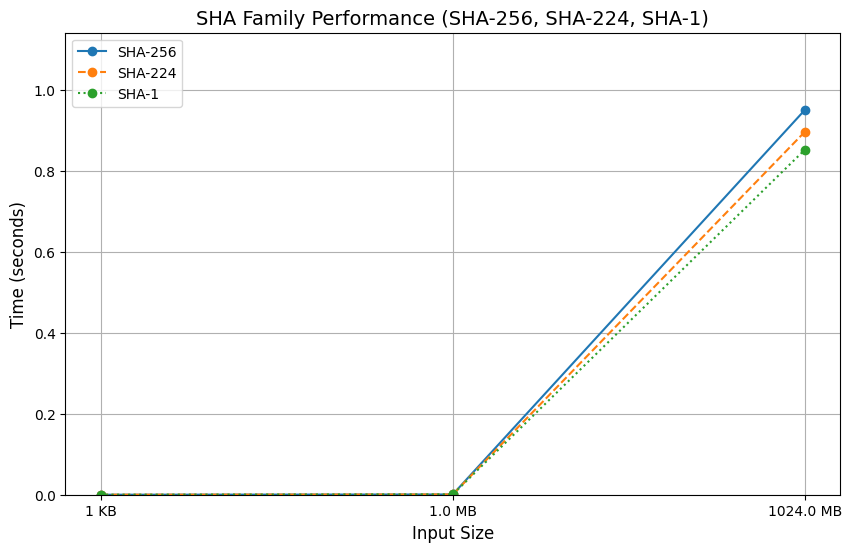

In [15]:
def visualize_sha_family(labels, sha256_times, sha224_times, sha1_times):
    """Visualize the performance comparison of SHA-256, SHA-224, and SHA-1."""
    plt.figure(figsize=(10, 6))
    
    # Plotting the performance
    plt.plot(labels, sha256_times, label='SHA-256', marker='o', linestyle='-')
    plt.plot(labels, sha224_times, label='SHA-224', marker='o', linestyle='--')
    plt.plot(labels, sha1_times, label='SHA-1', marker='o', linestyle=':')
    
    # Adding labels and title
    plt.xlabel('Input Size', fontsize=12)
    plt.ylabel('Time (seconds)', fontsize=12)
    plt.title('SHA Family Performance (SHA-256, SHA-224, SHA-1)', fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True)
    
    # Adjust the Y axis limits to enhance comparison (set a smaller range)
    plt.ylim(0, max(max(sha256_times), max(sha224_times), max(sha1_times)) * 1.2)

    # Show the plot
    plt.show()

if __name__ == "__main__":
    run_performance_comparison()
